<a href="https://colab.research.google.com/github/AlecYangLite/GreatFleet-Project/blob/main/Gold_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from datetime import datetime

# 获取当前日期
today = datetime.today().strftime('%Y-%m-%d')


In [ ]:
# 1. 获取历史黄金价格数据
gold = yf.download('GC=F', start='2009-01-01', end=today)  # COMEX 黄金期货数据
gold = gold[['Close']]  # 只使用收盘价
gold.dropna(inplace=True)

# 2. 数据预处理
scaler = MinMaxScaler(feature_range=(0,1))
gold_scaled = scaler.fit_transform(gold)

# 3. 检查数据
if gold.empty:
    raise ValueError("No data retrieved. Check the symbol or date range.")

[*********************100%***********************]  1 of 1 completed


In [ ]:
# 创建时间序列数据
def create_sequences(data, time_step=50, forecast_days=3):
    X, y = [], []
    for i in range(len(data)-time_step-forecast_days):
        X.append(data[i:(i+time_step), 0])
        y.append(data[(i+1):(i+forecast_days+1), 0])
    return np.array(X), np.array(y)

time_step = 50  # 时间步长
forecast_days = 3 # 预测未来3天的价格

X, y = create_sequences(gold_scaled, time_step, forecast_days)



In [ ]:
len(X)

4009

In [ ]:
# 划分训练集和测试集
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 调整形状以适配 LSTM 输入 (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


# 3. 构建 LSTM 模型
from tensorflow.keras.layers import Dropout

model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2), #添加Dropout层，丢弃20%的神经元
    LSTM(100, return_sequences=False),
    Dropout(0.2), #添加Dropout层
    Dense(100),
    Dense(forecast_days)
])

# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0118 - val_loss: 0.0023
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0012 - val_loss: 0.0145
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012 - val_loss: 0.0108
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.1332e-04 - val_loss: 0.0098
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.0353e-04 - val_loss: 0.0202
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.9769e-04 - val_loss: 0.0197
Epoch 9/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.3822e-04 - val_loss: 0.0106
Epoch 10/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.1936e-04 - val_loss: 0.0114
Epoch 11/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.3809e-04 - val_loss: 0.0312
Epoch 12/100
81/81 ━━━━━━━━━━━━━━━

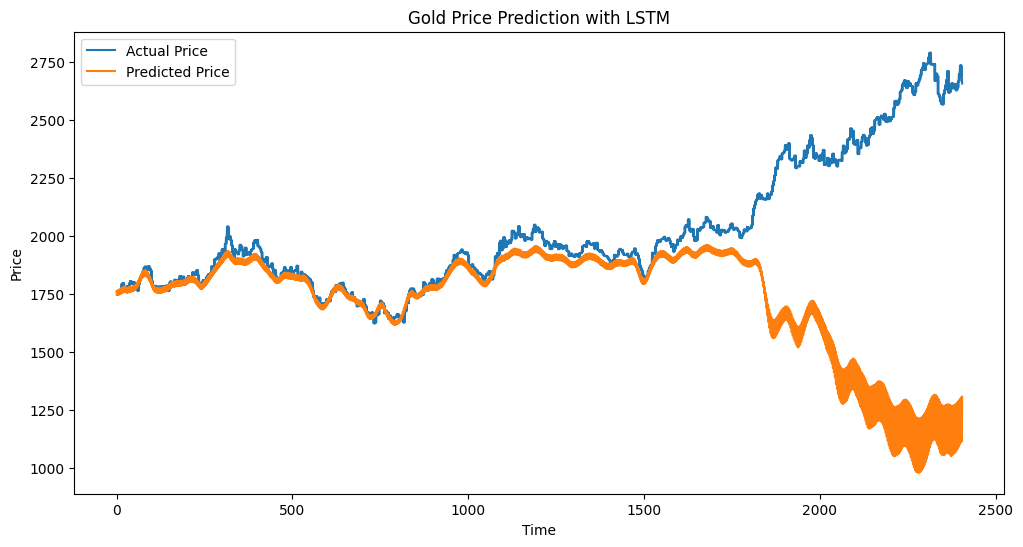

In [ ]:
# 4. 训练模型
history = model.fit(X_train, y_train, epochs=100, batch_size=40, validation_data=(X_test, y_test), verbose=1)

# 5. 进行预测
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))  # 反归一化

# 反归一化真实值
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# 6. 可视化预测结果
plt.figure(figsize=(12,6))
plt.plot(actual, label="Actual Price")
plt.plot(predictions, label="Predicted Price")
plt.legend()
plt.title("Gold Price Prediction with LSTM")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()